In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import NN_FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, get_default_lang_features, MOD_SPECIFIC_IMAGES, MOD_SPECIFIC_CAPTIONS
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN

# Zero-shot cross-modal decoding

In [2]:
models = ["random-flava", "clip", "flava", "imagebind", "blip2"]
all_data = load_results_data(models, recompute_acc_scores=False)


100%|██████████| 2110/2110 [00:00<00:00, 2544.66it/s]


In [3]:
data_models = all_data.copy()

data_models = data_models[data_models["mask"] == "whole_brain"]
data_models = data_models[data_models.surface == False]

data_models

,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat
0,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.855918,False,NaN,blip2_avg
1,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.824898,False,NaN,blip2_avg
2,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.928571,False,NaN,blip2_avg
3,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.876735,False,NaN,blip2_avg
4,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_mean,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.853980,False,NaN,blip2_avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7267,100000.0,random-flava,sub-07,avg,vision_features_mean,lang_features_mean,images,whole_brain,214739,pairwise_acc_mean,0.615510,False,NaN,random-flava_avg
7268,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.595963,False,fsaverage7,random-flava_matched
7269,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_captions,0.500414,False,fsaverage7,random-flava_matched
7270,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_images,0.704555,False,fsaverage7,random-flava_matched


In [4]:
data_cls_feats = data_models.copy()
for model in all_data.model.unique():
    data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]
    
data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]
data_matched_feats

,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat
100,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.850510,False,NaN,blip2_matched
101,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.794082,False,NaN,blip2_matched
102,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.918163,False,NaN,blip2_matched
103,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.856122,False,NaN,blip2_matched
176,100000.0,clip,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.860510,False,NaN,clip_matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7219,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_mean,0.850518,False,fsaverage7,imagebind_matched
7268,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.595963,False,fsaverage7,random-flava_matched
7269,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_captions,0.500414,False,fsaverage7,random-flava_matched
7270,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_images,0.704555,False,fsaverage7,random-flava_matched


In [5]:
def add_mean_cross_modal_and_within_modal_rows(data):
    extra_rows = []
    for model in data.model.unique():
        for mask in data["mask"].unique():
            for subject in SUBJECTS:
                data_model_subj = data[(data.model == model) & (data.subject == subject)]
                if pd.isna(mask):
                    data_model_subj = data_model_subj[pd.isna(data_model_subj['mask'])]
                else:
                    data_model_subj = data_model_subj[data_model_subj['mask'] == mask]
                # cross-modal
                cross_modal_train_images_eval_captions = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_CAPTIONS)]
                cross_modal_train_captions_eval_images = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_IMAGES)]
        
                if len(cross_modal_train_captions_eval_images) > 0:
                    assert len(cross_modal_train_images_eval_captions) == len(cross_modal_train_captions_eval_images) == 1
                    mean_acc = (cross_modal_train_images_eval_captions.value.item() + cross_modal_train_captions_eval_images.value.item()) / 2
            
                    mean_row = cross_modal_train_images_eval_captions.copy()
                    mean_row["training_mode"] = "cross-modal"
                    mean_row["metric"] = "mean"
                    mean_row["value"] = mean_acc
                    mean_row["condition"] = "cross-modal"
        
                    extra_rows.append(mean_row)
        
                # within-modal
                within_modal_captions = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_CAPTIONS)]
                within_modal_images = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_IMAGES)]
        
                if len(within_modal_captions) > 0:
                    assert len(within_modal_captions) == len(within_modal_images) == 1
                    mean_acc = (within_modal_captions.value.item() + within_modal_images.value.item()) / 2
            
                    mean_row = within_modal_captions.copy()
                    mean_row["training_mode"] = "within-modal"
                    mean_row["metric"] = "mean"
                    mean_row["value"] = mean_acc
                    mean_row["condition"] = "within-modal"
        
                    extra_rows.append(mean_row)

    if len(extra_rows) > 0:
        extra_rows = pd.concat(extra_rows)
        data = pd.concat((data, extra_rows), ignore_index=True)
    return data
    # data_matched_with_mean[data_matched_with_mean.metric == "mean"]

In [6]:
data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

In [7]:
DEFAULT_FEAT_OPTIONS = ["vision", "lang", "matched"]

def calc_model_feat_order(data, model_order, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in model_order:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in model_order:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

In [8]:
def create_zero_shot_cross_modal_plot(data, x_variable, ylim=(0.5, 1), y_variable="value", ylabel="pairwise_acc", row_variable="metric", hue_variable="condition", title=None):
    sns.set(font_scale=1.6)
    TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
    FEAT_ORDER = ["vision models", "language models", "multimodal models"]
    
    data_to_plot = data.copy()
    
    data_to_plot = data_to_plot[data_to_plot.training_mode != "modality-agnostic"]
    
    data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})
    
    data_to_plot.loc[((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "cross-modal"
    data_to_plot.loc[((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "within-modal"
    
    # model_feat_order = calc_model_feat_order(data_to_plot, model_order)
    
    
    metrics_order = [ACC_CAPTIONS, ACC_IMAGES, "mean"]
    
    height = 4.5
    aspect = 4
    
    condition_order = ["cross-modal", "within-modal"]
    
    for mode in ["captions", "images", "cross-modal", "within-modal"]:
        data_mode = data_to_plot[data_to_plot.training_mode == mode]
        for x_variable_value in data_to_plot[x_variable].unique():
            for condition in condition_order:
                length = len(data_mode[(data_mode[x_variable] == x_variable_value) & (data_mode.condition == condition)])
                expected_num_datapoints = len(SUBJECTS)
                if (length > 0) and (length != expected_num_datapoints):
                    message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {model} {mode})"
                    print(f"Warning: {message}")
    
    g = sns.catplot(data_to_plot, kind="bar", x=x_variable, y=y_variable, row=row_variable, row_order=metrics_order, col=None, height=height, aspect=aspect, hue=hue_variable, hue_order=condition_order,
                    palette=None, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)

    g.set(ylim=ylim, ylabel=ylabel, xlabel='')
    g.tick_params(axis='x', rotation=80)
    if title:
        g.fig.suptitle(title, y=1.03)
    return data_to_plot

model         condition   
blip2         cross-modal     0.716580
              within-modal    0.867633
clip          cross-modal     0.664924
              within-modal    0.872429
flava         cross-modal     0.722032
              within-modal    0.870031
imagebind     cross-modal     0.730728
              within-modal    0.885559
random-flava  cross-modal     0.508816
              within-modal    0.713302
Name: value, dtype: float64
model         condition   
blip2         cross-modal     6
              within-modal    6
clip          cross-modal     6
              within-modal    6
flava         cross-modal     6
              within-modal    6
imagebind     cross-modal     6
              within-modal    6
random-flava  cross-modal     6
              within-modal    6
Name: value, dtype: int64


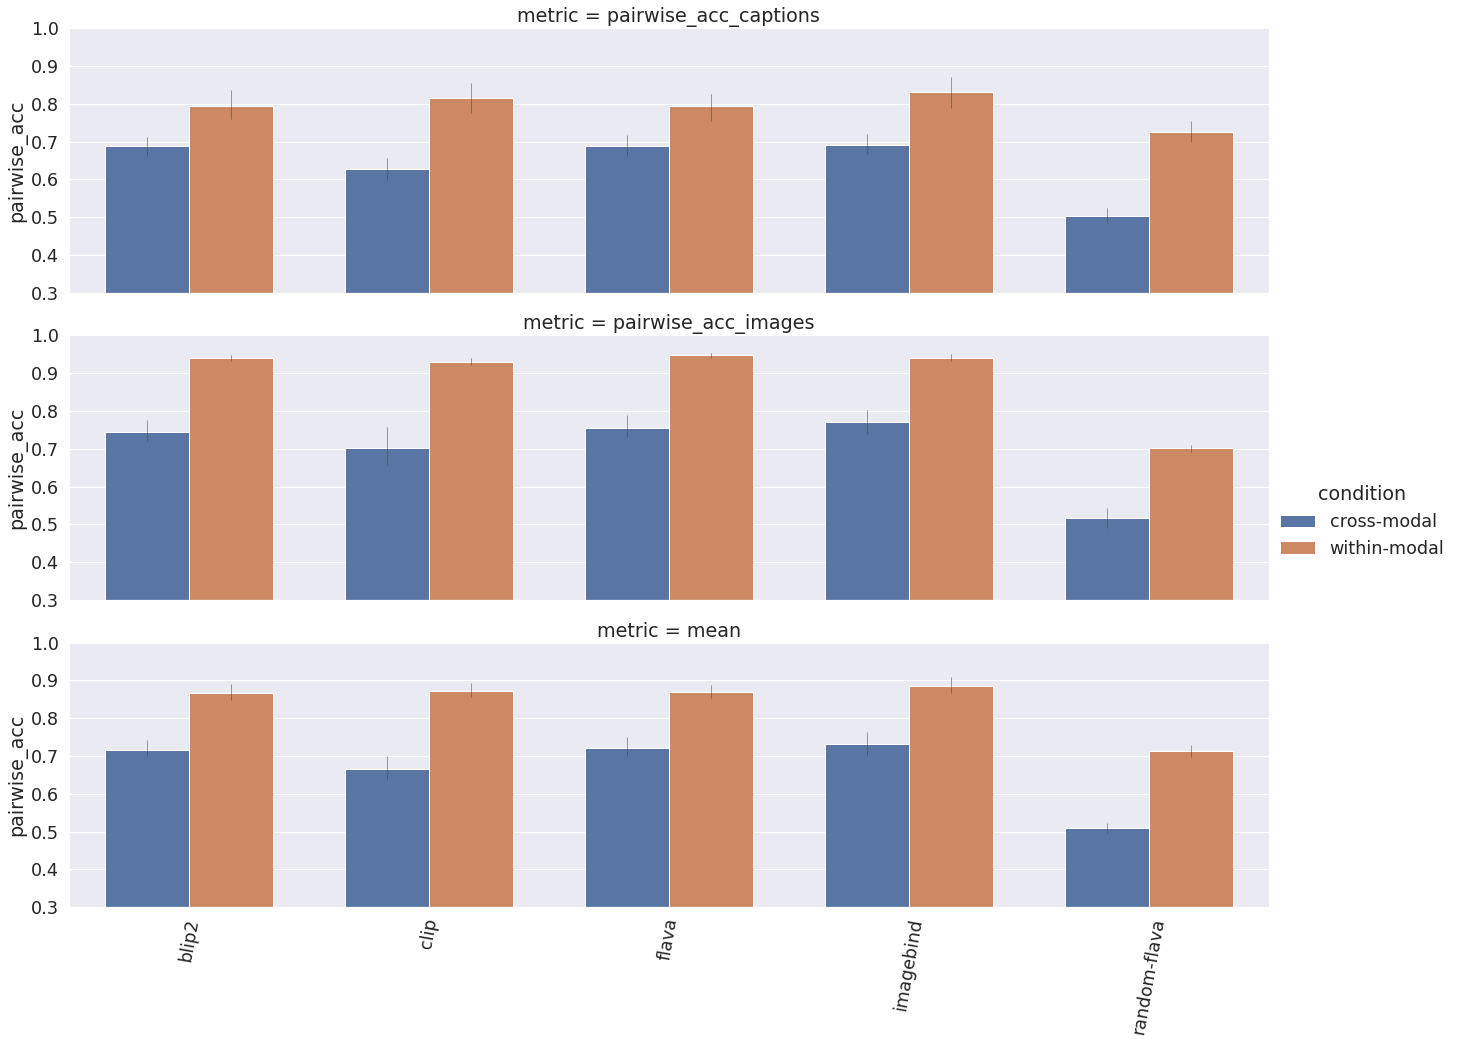

In [9]:
data_plotted = create_zero_shot_cross_modal_plot(data_matched_feats, "model", ylim=(0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"zero_shot_cross_modal.png"), bbox_inches='tight', pad_inches=0, dpi=300)

print(data_plotted[(data_plotted.metric == "mean")].groupby(["model", "condition"])['value'].mean())
print(data_plotted[(data_plotted.metric == "mean")].groupby(["model", "condition"])['value'].count())


# Zero-shot cross-modal decoding with Mask

In [10]:
def create_zero_shot_cross_modal_masks_plot(model):
    model_order = [model]
    resolution = "fsaverage7"
    
    data_models = all_data[all_data.model.isin(model_order)].copy()
    
    include_masks = [mask_name for mask_name in data_models["mask"].unique() if "thresh_0.001" in mask_name] 
    include_masks += ["whole_brain"]
    data_models = data_models[data_models["mask"].isin(include_masks)]
    # print(data_models["mask"].unique())
    
    # data_models = data_models[data_models.resolution == resolution]
    # data_models = data_models[data_models.surface == True]
    
    data_cls_feats = data_models.copy()
    for model in data_models.model.unique():
        data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]
    
    data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]
    
    data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)
    data_plotted = create_zero_shot_cross_modal_plot(data_matched_feats, x_variable="mask", title=model)
    # print(data_plotted[(data_plotted.metric == "mean")].groupby(["mask", "condition"]).agg(mean_val=('value', 'mean'), count=('value', 'count')))
    return data_plotted

,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat,condition
24,1000.0,flava,sub-01,multimodal models,vision_features_cls,lang_features_cls,captions,whole_brain,162649,pairwise_acc_modality_agnostic,0.800725,False,fsaverage7,flava_matched,NaN
25,1000.0,flava,sub-01,multimodal models,vision_features_cls,lang_features_cls,captions,whole_brain,162649,pairwise_acc_captions,0.834161,False,fsaverage7,flava_matched,within-modal
26,1000.0,flava,sub-01,multimodal models,vision_features_cls,lang_features_cls,captions,whole_brain,162649,pairwise_acc_images,0.744099,False,fsaverage7,flava_matched,cross-modal
27,1000.0,flava,sub-01,multimodal models,vision_features_cls,lang_features_cls,captions,whole_brain,162649,pairwise_acc_mean,0.789130,False,fsaverage7,flava_matched,NaN
28,1.0,flava,sub-01,multimodal models,vision_features_cls,lang_features_cls,captions,thresh_0.001_left_cluster_0,769,pairwise_acc_modality_agnostic,0.707971,True,fsaverage7,flava_matched,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,100.0,flava,sub-04,multimodal models,vision_features_cls,lang_features_cls,within-modal,thresh_0.001,1366,mean,0.632402,True,fsaverage7,flava_matched,within-modal
380,10000.0,flava,sub-05,multimodal models,vision_features_cls,lang_features_cls,cross-modal,thresh_0.001,1340,mean,0.627226,True,fsaverage7,flava_matched,cross-modal
381,10000.0,flava,sub-05,multimodal models,vision_features_cls,lang_features_cls,within-modal,thresh_0.001,1340,mean,0.685093,True,fsaverage7,flava_matched,within-modal
382,1.0,flava,sub-07,multimodal models,vision_features_cls,lang_features_cls,cross-modal,thresh_0.001,1348,mean,0.659420,True,fsaverage7,flava_matched,cross-modal


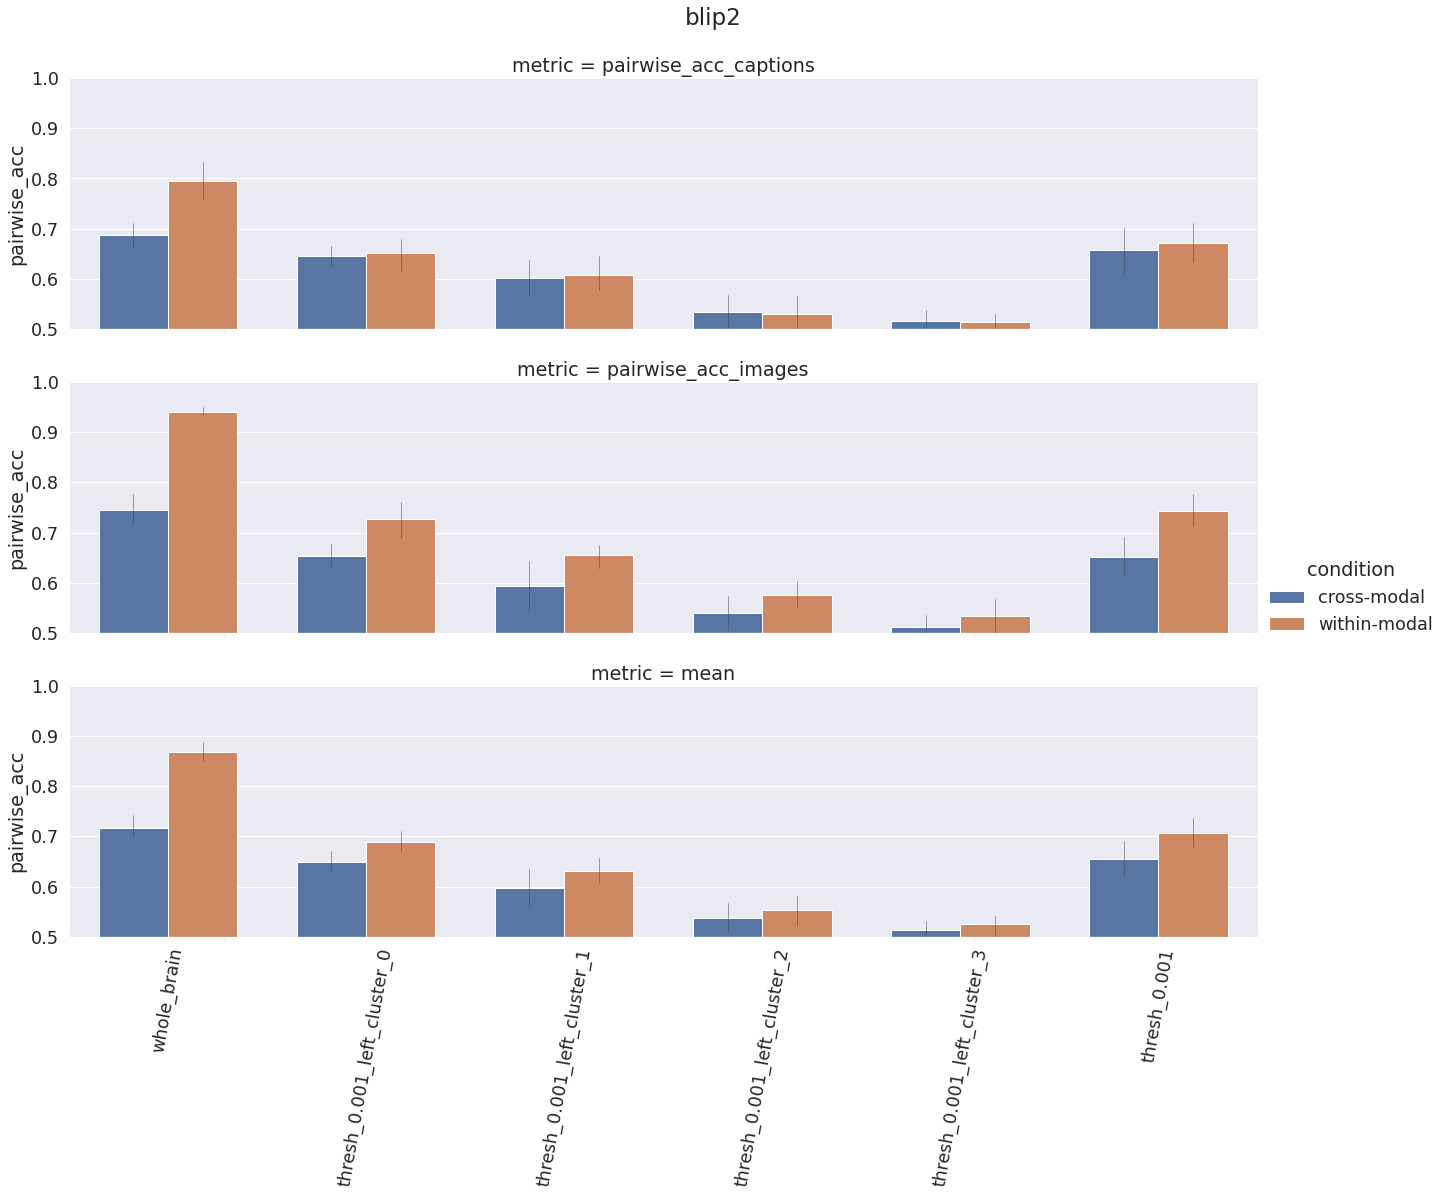

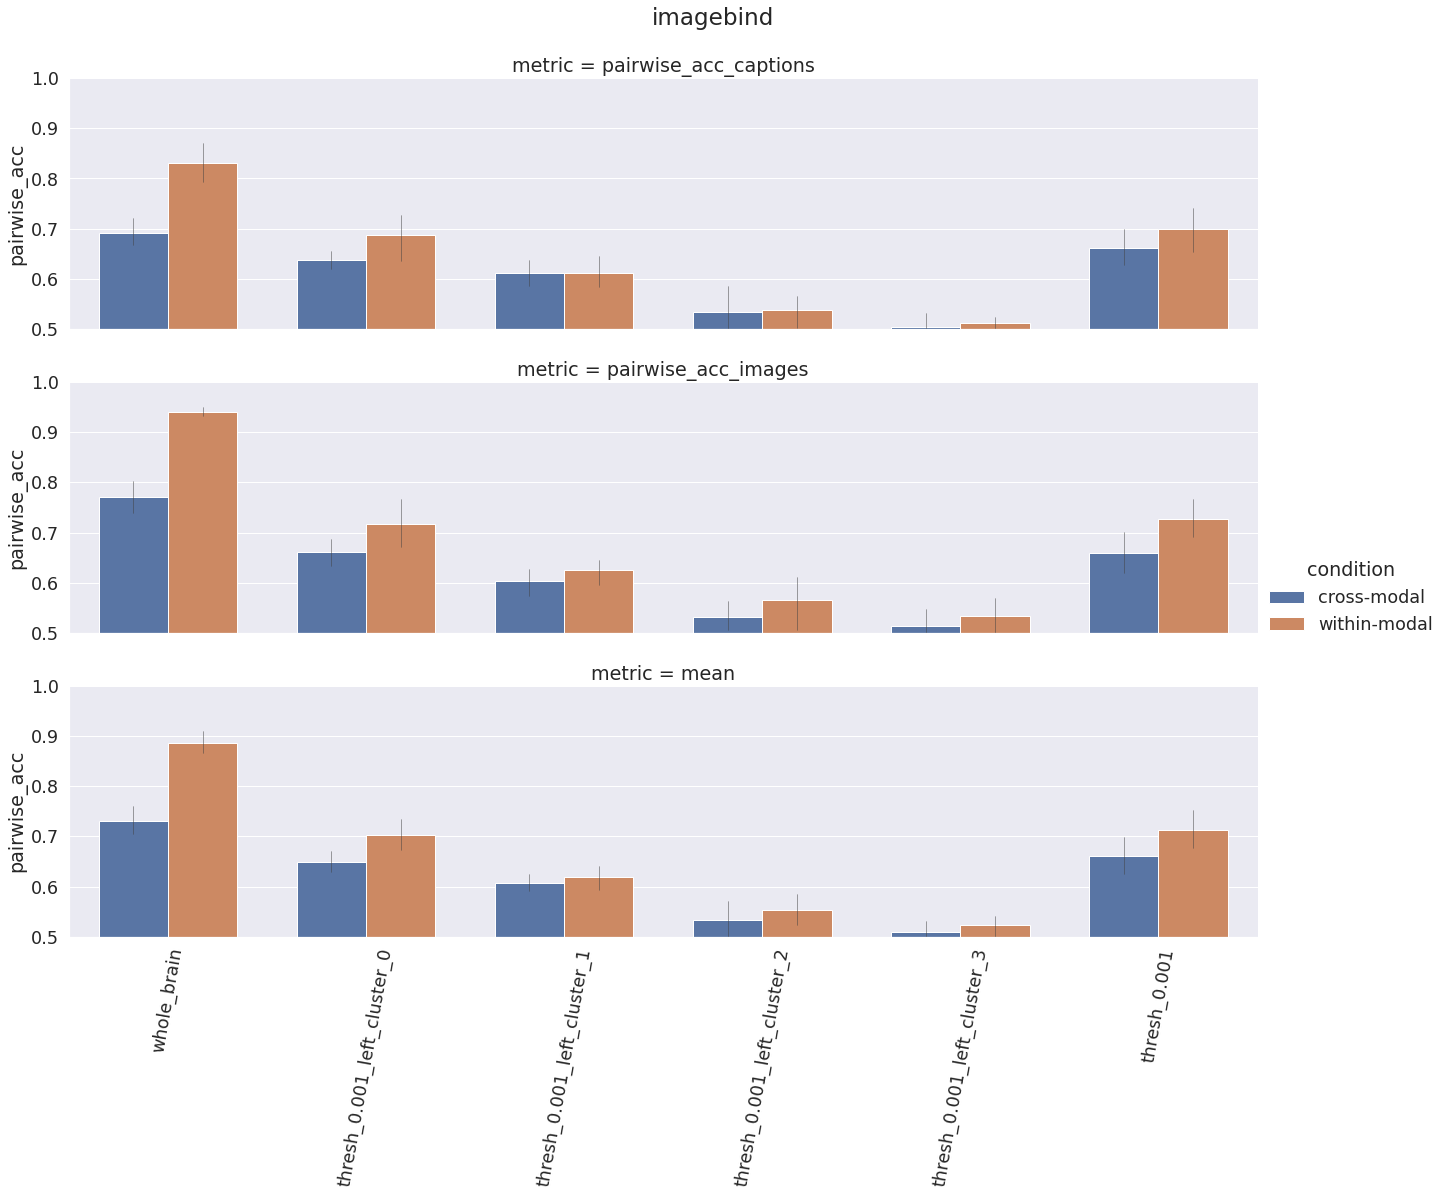

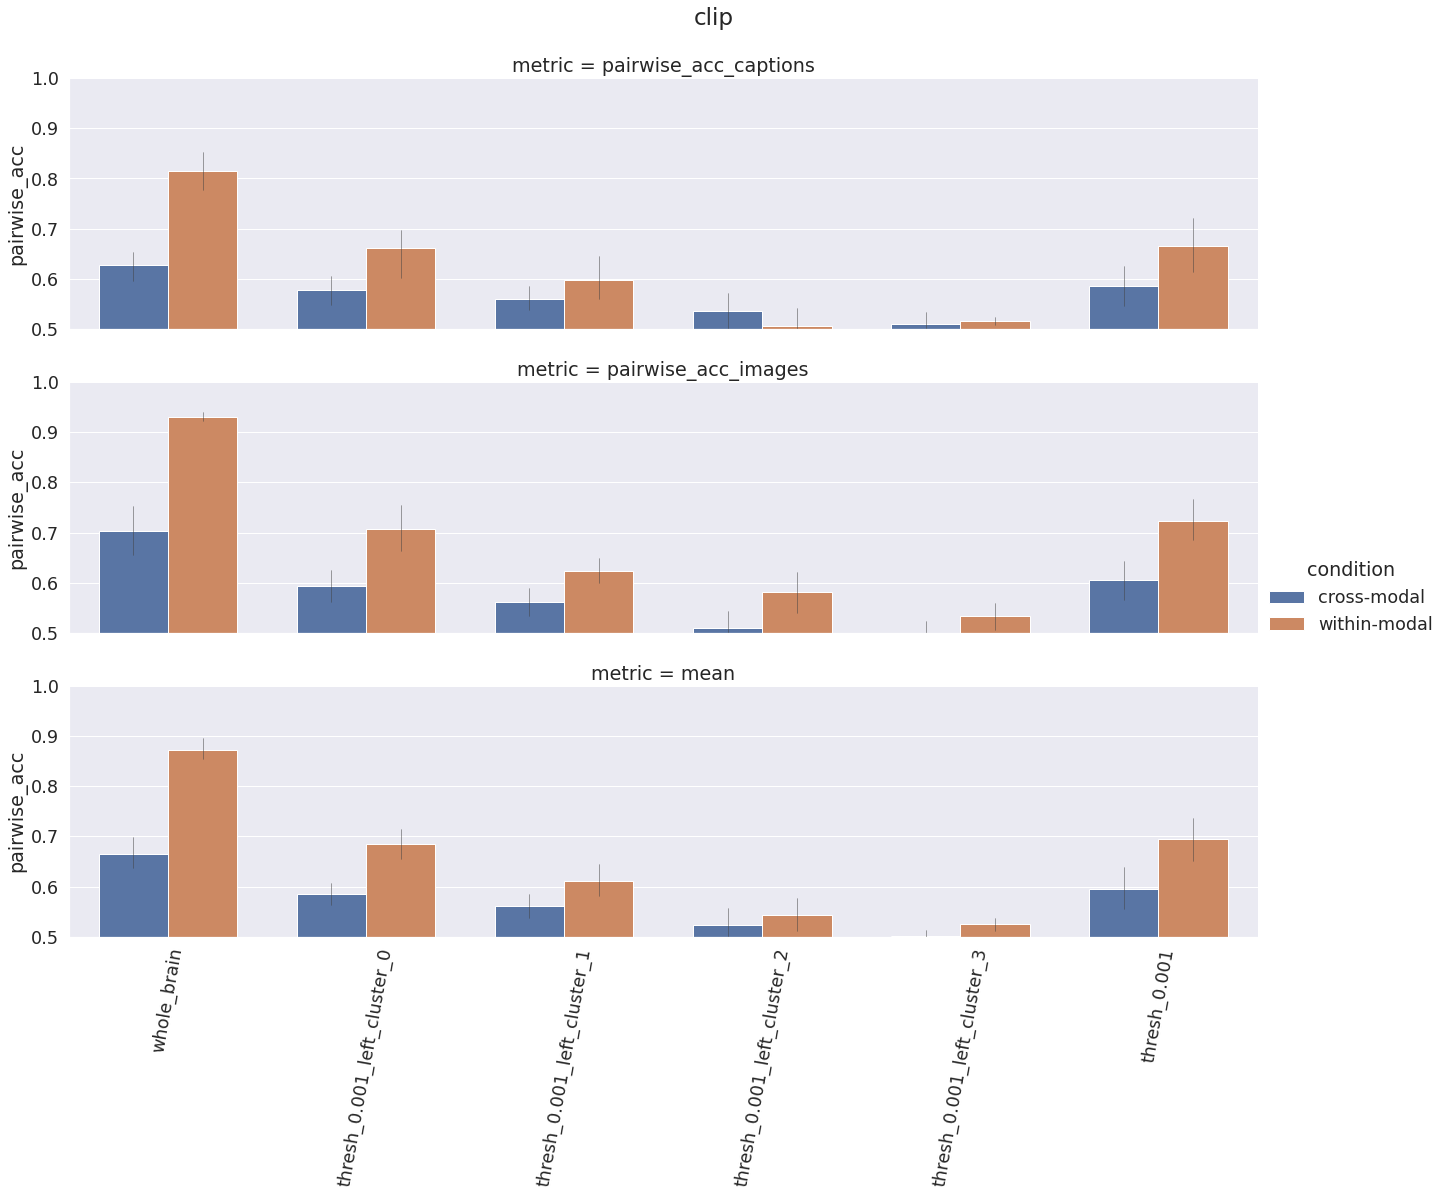

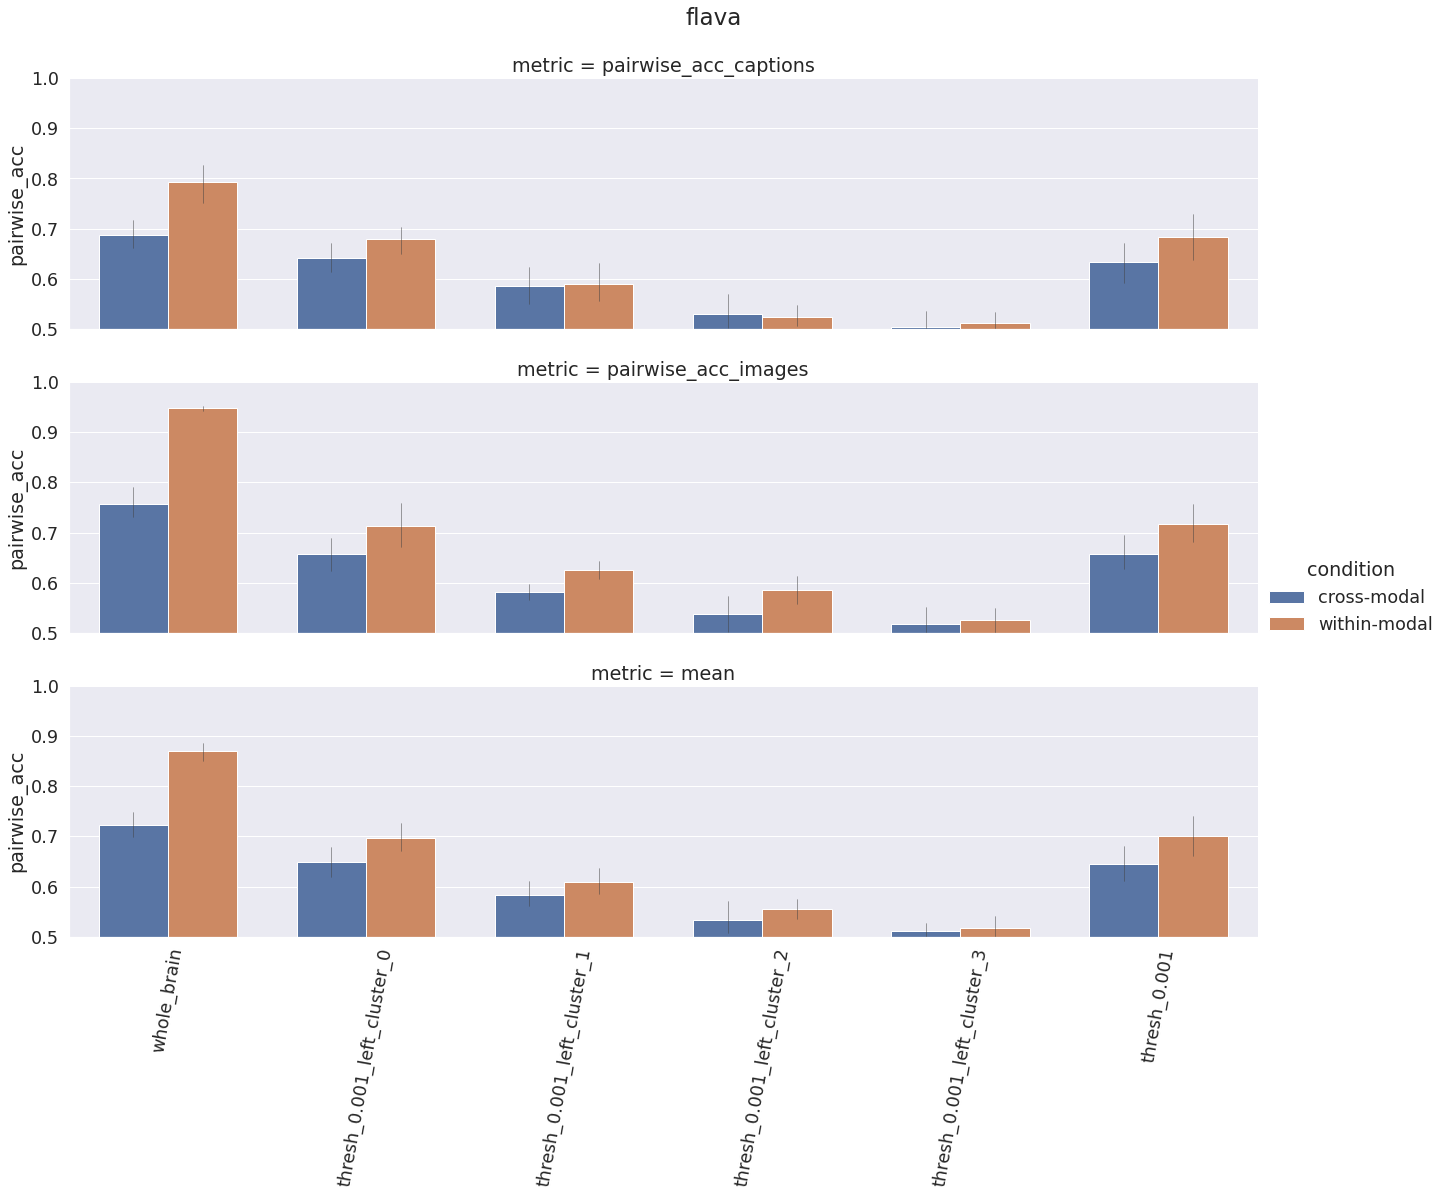

In [11]:
data_plotted = create_zero_shot_cross_modal_masks_plot("blip2")
create_zero_shot_cross_modal_masks_plot("imagebind")
create_zero_shot_cross_modal_masks_plot("clip")
create_zero_shot_cross_modal_masks_plot("flava")

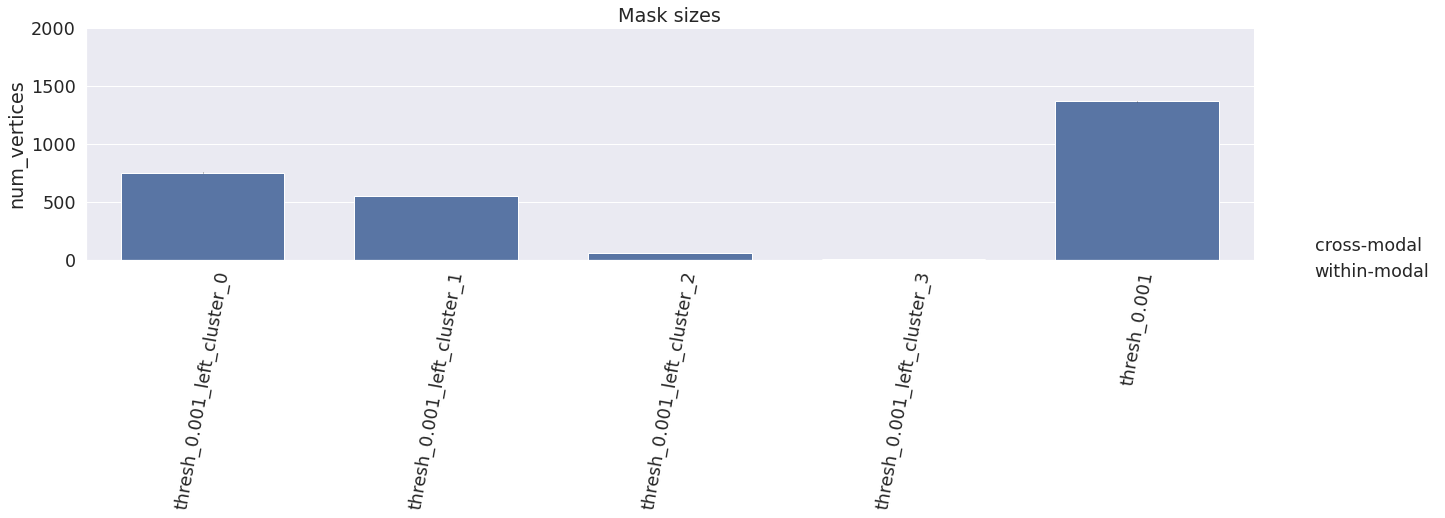

In [12]:
data_plotted = data_plotted[data_plotted["mask"] != "whole_brain"]
data_plotted = create_zero_shot_cross_modal_plot(data_plotted, x_variable="mask", y_variable="num_voxels", ylim=(0, 2000), ylabel="num_vertices", row_variable=None, hue_variable=None)
_ = plt.title("Mask sizes")
# print(data_plotted[(data_plotted.metric == "mean")].groupby(["mask", "condition"])['num_voxels'].mean())


# Zero-shot cross-modal decoding with GloW

In [13]:
models = ["glow", "glow-contrastive"]

data_models = load_results_data(models)
data_models

100%|██████████| 2110/2110 [00:00<00:00, 3405.22it/s]


,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,model_feat
0,100000.0,glow-contrastive,sub-01,lang,vision_features_mean,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.846735,False,glow-contrastive_lang
1,100000.0,glow-contrastive,sub-01,lang,vision_features_mean,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.813673,False,glow-contrastive_lang
2,100000.0,glow-contrastive,sub-01,lang,vision_features_mean,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.914490,False,glow-contrastive_lang
3,100000.0,glow-contrastive,sub-01,lang,vision_features_mean,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.864082,False,glow-contrastive_lang
4,100000.0,glow-contrastive,sub-01,matched,vision_features_mean,lang_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.846939,False,glow-contrastive_matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,100000.0,glow,sub-07,matched,vision_features_mean,lang_features_cls,images,whole_brain,214739,pairwise_acc_mean,0.851020,False,glow_matched
428,100000.0,glow,sub-07,vision,vision_features_mean,lang_features_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.800204,False,glow_vision
429,100000.0,glow,sub-07,vision,vision_features_mean,lang_features_cls,images,whole_brain,214739,pairwise_acc_captions,0.735918,False,glow_vision
430,100000.0,glow,sub-07,vision,vision_features_mean,lang_features_cls,images,whole_brain,214739,pairwise_acc_images,0.942041,False,glow_vision


In [14]:
data_cls_feats = data_models.copy()
# for model in all_data.model.unique():
#     data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]

data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]


In [15]:
data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

model
glow                0.728878
glow-contrastive    0.727092
Name: value, dtype: float64
model
glow                6
glow-contrastive    6
Name: value, dtype: int64


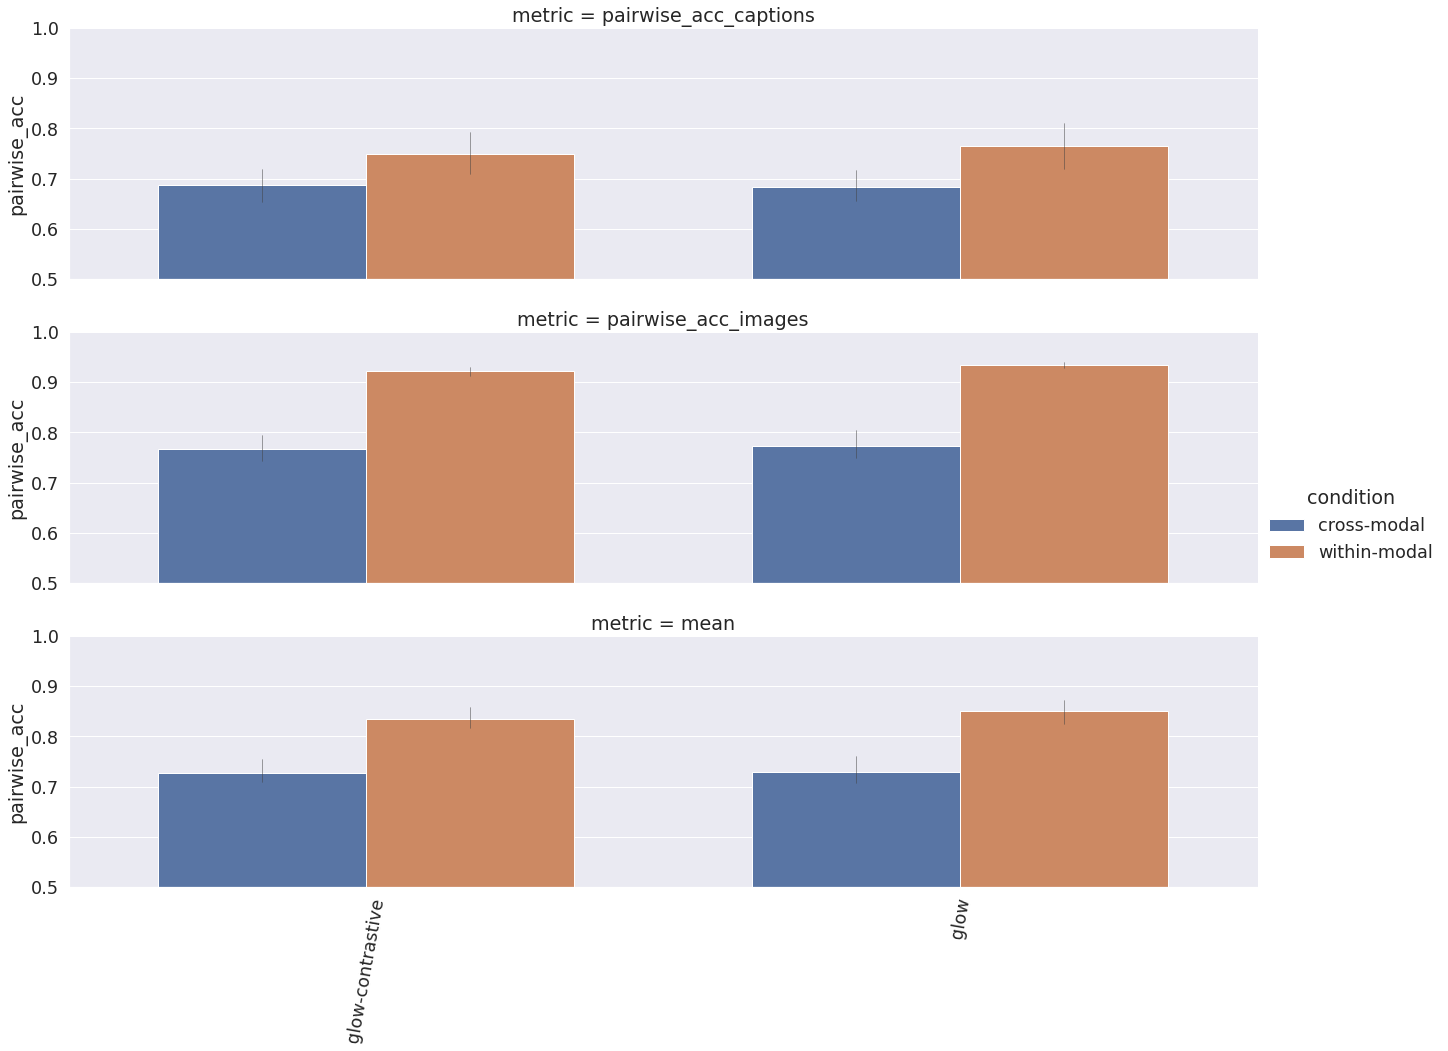

In [16]:
data_plotted = create_zero_shot_cross_modal_plot(data_matched_feats, "model")
plt.savefig(os.path.join(RESULTS_DIR, f"zero_shot_cross_modal_glow.png"), bbox_inches='tight', pad_inches=0, dpi=300)

print(data_plotted[(data_plotted.training_mode == "cross-modal") & (data_plotted.metric == "mean")].groupby("model")['value'].mean())
print(data_plotted[(data_plotted.training_mode == "cross-modal") & (data_plotted.metric == "mean")].groupby("model")['value'].count())
